In [1]:
import os
from glob import glob
import open3d as o3d
from tqdm.notebook import tqdm
import numpy as np
import time
from scipy.spatial import cKDTree
from lidsor_filter import filtering_lidsor_cpp

In [123]:
def filter_point_cloud(points, k=30, s=2.0, r=1.5, i_threshold=25, d_threshold=25.0):
    """
    Point cloud filtering function
    
    Parameters:
    points: Input point cloud (N x 3 numpy array)
    k: Number of nearest neighbors
    s: Multiplier for standard deviation
    r: Multiplier for range
    i_threshold: Intensity threshold
    d_threshold: Distance threshold
    """
    # Primary filtering (based on distance)
    distances = np.linalg.norm(points, axis=1)
    primary_mask = distances < d_threshold
    Q = points[primary_mask]
    
    # Build KD tree
    kdtree = cKDTree(Q)
    
    # Search for nearest neighbors for each point
    mean_distances = []
    for point in Q:
        distances, _ = kdtree.query(point, k=k)
        mean_distances.append(np.mean(distances))
    
    mean_distances = np.array(mean_distances)
    
    # Calculate global threshold
    mu = np.mean(mean_distances)
    sigma = np.std(mean_distances)
    T_g = mu + sigma * s
    
    # Filtering based on dynamic threshold
    filtered_points = []
    for i, point in enumerate(Q):
        distance = np.linalg.norm(point)
        T_d = T_g * r * (distance / d_threshold)
        
        # Calculate intensity (using the absolute value of the Z coordinate)
        intensity = abs(point[3])
        
        if mean_distances[i] <= T_d or intensity >= i_threshold:
            filtered_points.append(point)
    
    # Add points not excluded in primary filtering
    filtered_points.extend(points[~primary_mask])
    
    return np.array(filtered_points)


def compute_pointwise_distance(pcd, k=30):
    """Calculate the average distance and standard deviation to the nearest neighbor for each point"""
    distances = []
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    for i in range(np.asarray(pcd.points).shape[0]):
        [_, idx, dists] = kdtree.search_knn_vector_3d(pcd.points[i], k)
        avg_dist = np.mean(np.sqrt(dists[1:]))  # Average distance to nearest neighbor excluding itself
        distances.append(avg_dist)
    return np.array(distances)

def dynamic_outlier_filter(pcd, distances, intensity, s=2.0, distance_threshold=25.0, intensity_threshold=25.0):
    """LIDSOR filter: filtering based on dynamic thresholds"""
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    
    # Calculate dynamic threshold
    threshold_distance = mean_distance + s * std_distance
    
    filtered_points = []
    filtered_colors = []
    for i, (point, current_intensity) in enumerate(zip(pcd.points, intensity)):
        # Keep only points that meet the distance and intensity conditions
        if distances[i] < threshold_distance and distances[i] < distance_threshold and current_intensity > intensity_threshold:
            filtered_points.append(point)
            # Convert intensity value to RGB value in the range of 0-1
            normalized_intensity = min(current_intensity / 255.0, 1.0)  # Normalize by 255
            filtered_colors.append([normalized_intensity, normalized_intensity, normalized_intensity])

    # Create a new point cloud for the filtering results
    return np.array(filtered_points)

def filtering_lidsor(npy_points, k=30, s=2.0, i_threshold=25, d_threshold=25.0, scaling_factor=110.0):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(npy_points[:, :3])
    distances = compute_pointwise_distance(pcd, k)
    intensity = npy_points[:, 3]

    if intensity.max() <= 1.0:
        intensity = intensity * scaling_factor
        
    return dynamic_outlier_filter(pcd, distances, intensity, s, d_threshold, i_threshold)


In [5]:
filtered_npy

[[-18.60993766784668, 1.0913245677947998, 0.07850110530853271],
 [-21.710643768310547, 1.319725751876831, 0.10286235809326172],
 [-22.85694122314453, 1.3834158182144165, 0.09311938285827637],
 [-21.534372329711914, 1.38338303565979, 0.15569114685058594],
 [-22.283803939819336, 1.4242489337921143, 0.14640212059020996],
 [-23.524761199951172, 1.4793998003005981, 0.15475130081176758],
 [-28.168550491333008, 1.6897058486938477, 0.09510338306427002],
 [-28.954591751098633, 1.7321659326553345, 0.10242486000061035],
 [-27.59480857849121, 1.7306394577026367, 0.16216039657592773],
 [-28.604145050048828, 1.7857812643051147, 0.16088271141052246],
 [-30.308990478515625, 1.8631757497787476, 0.18733501434326172],
 [-33.738426208496094, 1.9200154542922974, 0.14265048503875732],
 [-36.059913635253906, 2.141841173171997, 0.16283762454986572],
 [-36.9542236328125, 2.1897289752960205, 0.1923971176147461],
 [-35.90934371948242, 2.207082748413086, 0.2528839111328125],
 [-37.14275360107422, 2.27423453330993

In [6]:
bin_path = '/mnt/d/bin/mini'
bin_path_list = glob(f"{bin_path}/*.bin")

bin_list = []
o3d_bin_list = []
filtered_bin_list = []
o3d_filtered_bin_list = []
time_list = []
for bin_path in tqdm(bin_path_list):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # decode intensity
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    o3d_bin_list.append(pcd)

    start_time = time.time()

    # filtered_npy = filtering_lidsor(points, k=30, s=2.0, i_threshold=0.1, d_threshold=50.0)
    filtered_npy = filtering_lidsor_cpp(points, k=30, s=2.0, i_threshold=0.1, d_threshold=50.0)

    end_time = time.time()
    time_list.append(end_time - start_time)

    # filtered_bin_list.append(filtered_points)
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(np.asarray(filtered_npy)[:, :3])
    o3d_filtered_bin_list.append(filtered_pcd)
    bin_list.append(points)
    
    # o3d.io.write_point_cloud(bin_path, o3d.geometry.PointCloud(points=o3d.utility.Vector3dVector(filtered_points)))


  0%|          | 0/25 [00:00<?, ?it/s]

In [7]:
print(f"time: {np.mean(time_list)}, std: {np.std(time_list)}")

time: 0.4710231590270996, std: 0.020147247717285665


In [133]:
from multiprocessing import Process

def show_visualization1():
    idx = 20
    o3d.visualization.draw_geometries([o3d_bin_list[idx]])

def show_visualization2():
    idx = 20
    o3d.visualization.draw_geometries([o3d_filtered_bin_list[idx]])

# 2つのプロセスを作成
p1 = Process(target=show_visualization1)
p2 = Process(target=show_visualization2)

# プロセスを開始
p1.start()
p2.start()

# プロセスの終了を待機
p1.join()
p2.join()

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [44]:
idx = 10
print(f"num of points: {bin_list[idx].shape[0]} -> {filtered_bin_list[idx].shape[0]}")

num of points: 245892 -> 217566


In [46]:
print(f"num of points: {o3d_bin_list[idx]} -> {o3d_filtered_bin_list[idx]}")


num of points: PointCloud with 245892 points. -> PointCloud with 245892 points.


In [109]:
# ... existing code ...

# 差分の可視化用の関数を定義
def visualize_point_clouds_with_difference(original_pcd, filtered_pcd):
    # 元の点群を青色に設定
    original_pcd.paint_uniform_color([0, 0, 1])  # 青色
    
    # フィルタリング後の点群を緑色に設定
    filtered_pcd.paint_uniform_color([0, 1, 0])  # 緑色
    
    # 点群をnumpy配列に変換
    original_points = np.asarray(original_pcd.points)
    filtered_points = np.asarray(filtered_pcd.points)
    
    # 差分点群の作成（高速化版）
    # 各点について、フィルタリング後の点群に存在するかをチェック
    mask = ~np.isin(original_points.view([('', original_points.dtype)]*original_points.shape[1]),
                    filtered_points.view([('', filtered_points.dtype)]*filtered_points.shape[1]))
    diff_points = original_points[mask.any(axis=1)]
    
    # 差分点群の作成
    diff_cloud = o3d.geometry.PointCloud()
    diff_cloud.points = o3d.utility.Vector3dVector(diff_points)
    
    # 差分点群を赤色に設定
    diff_cloud.paint_uniform_color([1, 0, 0])  # 赤色
    
    # 可視化
    print(f"original num of points: {original_points.shape[0]}")
    print(f"filtered num of points: {filtered_points.shape[0]}")
    print(f"num of diff points: {diff_points.shape[0]}")
    o3d.visualization.draw_geometries([original_pcd, filtered_pcd, diff_cloud])
    # o3d.visualization.draw_geometries([diff_cloud])


# 可視化の実行
idx = 10
visualize_point_clouds_with_difference(o3d_bin_list[idx], o3d_filtered_bin_list[idx])

original num of points: 245892
filtered num of points: 215418
num of diff points: 30473


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


/home/fukuda/anaconda3/envs/terrain_mapping/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fukuda/anaconda3/envs/terrain_mapping/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fukuda/anaconda3/envs/terrain_mapping/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fukuda/anaconda3/envs/terrain_mapping/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/fukuda/anaconda3/envs/terrain_mapping/

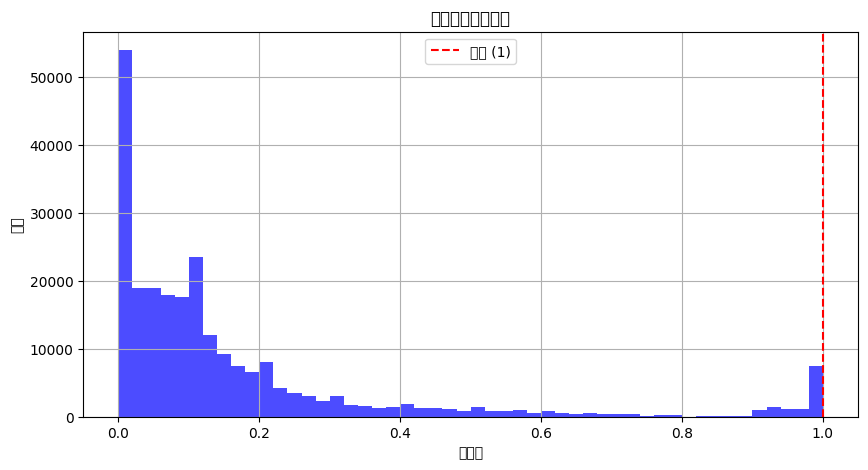

全点数: 243973
反射率が1以下の点数: 243973


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


In [98]:
# 反射率の分析と可視化
def analyze_intensity(points, intensity_th=25):
    """
    点群の反射率を分析・可視化する関数
    
    Parameters:
    points: 入力点群データ (N x 4 numpy配列、4列目が反射率)
    intensity_th: 反射率の閾値
    """
    # 反射率の取得
    intensities = np.abs(points[:, 3])
    
    # ヒストグラムの描画
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.hist(intensities, bins=50, color='blue', alpha=0.7)
    plt.axvline(x=intensity_th, color='r', linestyle='--', label=f'閾値 ({intensity_th})')
    plt.xlabel('反射率')
    plt.ylabel('頻度')
    plt.title('点群の反射率分布')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 反射率に基づく点群の可視化
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    
    # 反射率が閾値以下の点を赤色、それ以外を青色に
    colors = np.zeros((len(points), 3))
    colors[intensities <= intensity_th] = [1, 0, 0]  # 赤色
    colors[intensities > intensity_th] = [0, 0, 1]   # 青色
    
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    print(f"全点数: {len(points)}")
    print(f"反射率が{intensity_th}以下の点数: {np.sum(intensities <= intensity_th)}")
    o3d.visualization.draw_geometries([pcd])

# 特定のインデックスの点群に対して分析を実行
idx = 20  # 任意のインデックスを指定
analyze_intensity(bin_list[idx], intensity_th=1)

In [92]:
import numpy as np
import open3d as o3d

# パラメータ設定
k = 20  # 近傍点数
s = 1.5  # 標準偏差の乗数
distance_threshold = 25.0  # 雪天での距離閾値（例として設定）
intensity_threshold = 25.0  # 雪天での反射強度閾値（例として設定）

def compute_pointwise_distance(pcd):
    """各点から最近傍点までの平均距離と標準偏差を計算する"""
    distances = []
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    for i in range(np.asarray(pcd.points).shape[0]):
        [_, idx, dists] = kdtree.search_knn_vector_3d(pcd.points[i], k)
        avg_dist = np.mean(np.sqrt(dists[1:]))  # 自身を除く最近傍距離の平均
        distances.append(avg_dist)
    return np.array(distances)

def dynamic_outlier_filter(pcd, distances, intensity, s, distance_threshold, intensity_threshold):
    """LIDSORフィルタ：動的閾値によるフィルタリング"""
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)
    
    # 動的閾値の計算
    threshold_distance = mean_distance + s * std_distance
    
    filtered_points = []
    filtered_colors = []
    for i, (point, current_intensity) in enumerate(zip(pcd.points, intensity)):
        # 距離と強度の条件を満たす点のみを保持
        if distances[i] < threshold_distance and distances[i] < distance_threshold and current_intensity > intensity_threshold:
            filtered_points.append(point)
            # 強度値を0-1の範囲のRGB値に変換
            normalized_intensity = min(current_intensity / 255.0, 1.0)  # 255で正規化
            filtered_colors.append([normalized_intensity, normalized_intensity, normalized_intensity])

    # フィルタリング結果の新しい点群を作成
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(np.array(filtered_points))
    filtered_pcd.colors = o3d.utility.Vector3dVector(np.array(filtered_colors))
    return filtered_pcd

# 点群データの読み込み
idx = 10
pcd = o3d_bin_list[idx]

# 各点の距離（平均距離）を計算
distances = compute_pointwise_distance(pcd)

# 点群に反射強度データがあると仮定し、強度データを正規化
intensity = bin_list[idx][:, 3]

# LIDSORフィルタを適用
filtered_pcd = dynamic_outlier_filter(pcd, distances, intensity, s, distance_threshold, intensity_threshold)

# 結果を保存または表示
# o3d.io.write_point_cloud("filtered_point_cloud.ply", filtered_pcd)
# o3d.visualization.draw_geometries([filtered_pcd])
return filter

TypeError: search_knn_vector_3d(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cuda.pybind.geometry.KDTreeFlann, query: numpy.ndarray[numpy.float64[3, 1]], knn: int) -> Tuple[int, open3d.cuda.pybind.utility.IntVector, open3d.cuda.pybind.utility.DoubleVector]

Invoked with: <open3d.cuda.pybind.geometry.KDTreeFlann object at 0x7f20a0b28570>, array([-8.798083  ,  0.5641726 , -0.05315876,  0.        ], dtype=float32), 20

In [85]:
distances.shape

(245892,)

In [82]:
bin_list[0]

array([[-8.4886284e+00,  5.6160879e-01,  1.1738896e-02,  0.0000000e+00],
       [-1.4839990e+01,  9.8810530e-01,  9.1077685e-02,  0.0000000e+00],
       [-1.8609938e+01,  1.0913246e+00,  7.8501105e-02,  9.9999994e-01],
       ...,
       [-2.3229038e+01,  1.4006829e+00,  6.8482904e+00,  1.5000000e+01],
       [-2.4093674e+01,  1.4453876e+00,  7.6293068e+00,  2.8000000e+01],
       [-1.6738981e+01,  1.0052159e+00,  8.0091438e+00,  2.7000000e+01]],
      dtype=float32)